Overconfident: MACE: 0.2096, RMSCE: 0.2370, MA: 0.2117
Well-calibrated: MACE: 0.0115, RMSCE: 0.0139, MA: 0.0115
Underconfident: MACE: 0.1948, RMSCE: 0.2175, MA: 0.1968


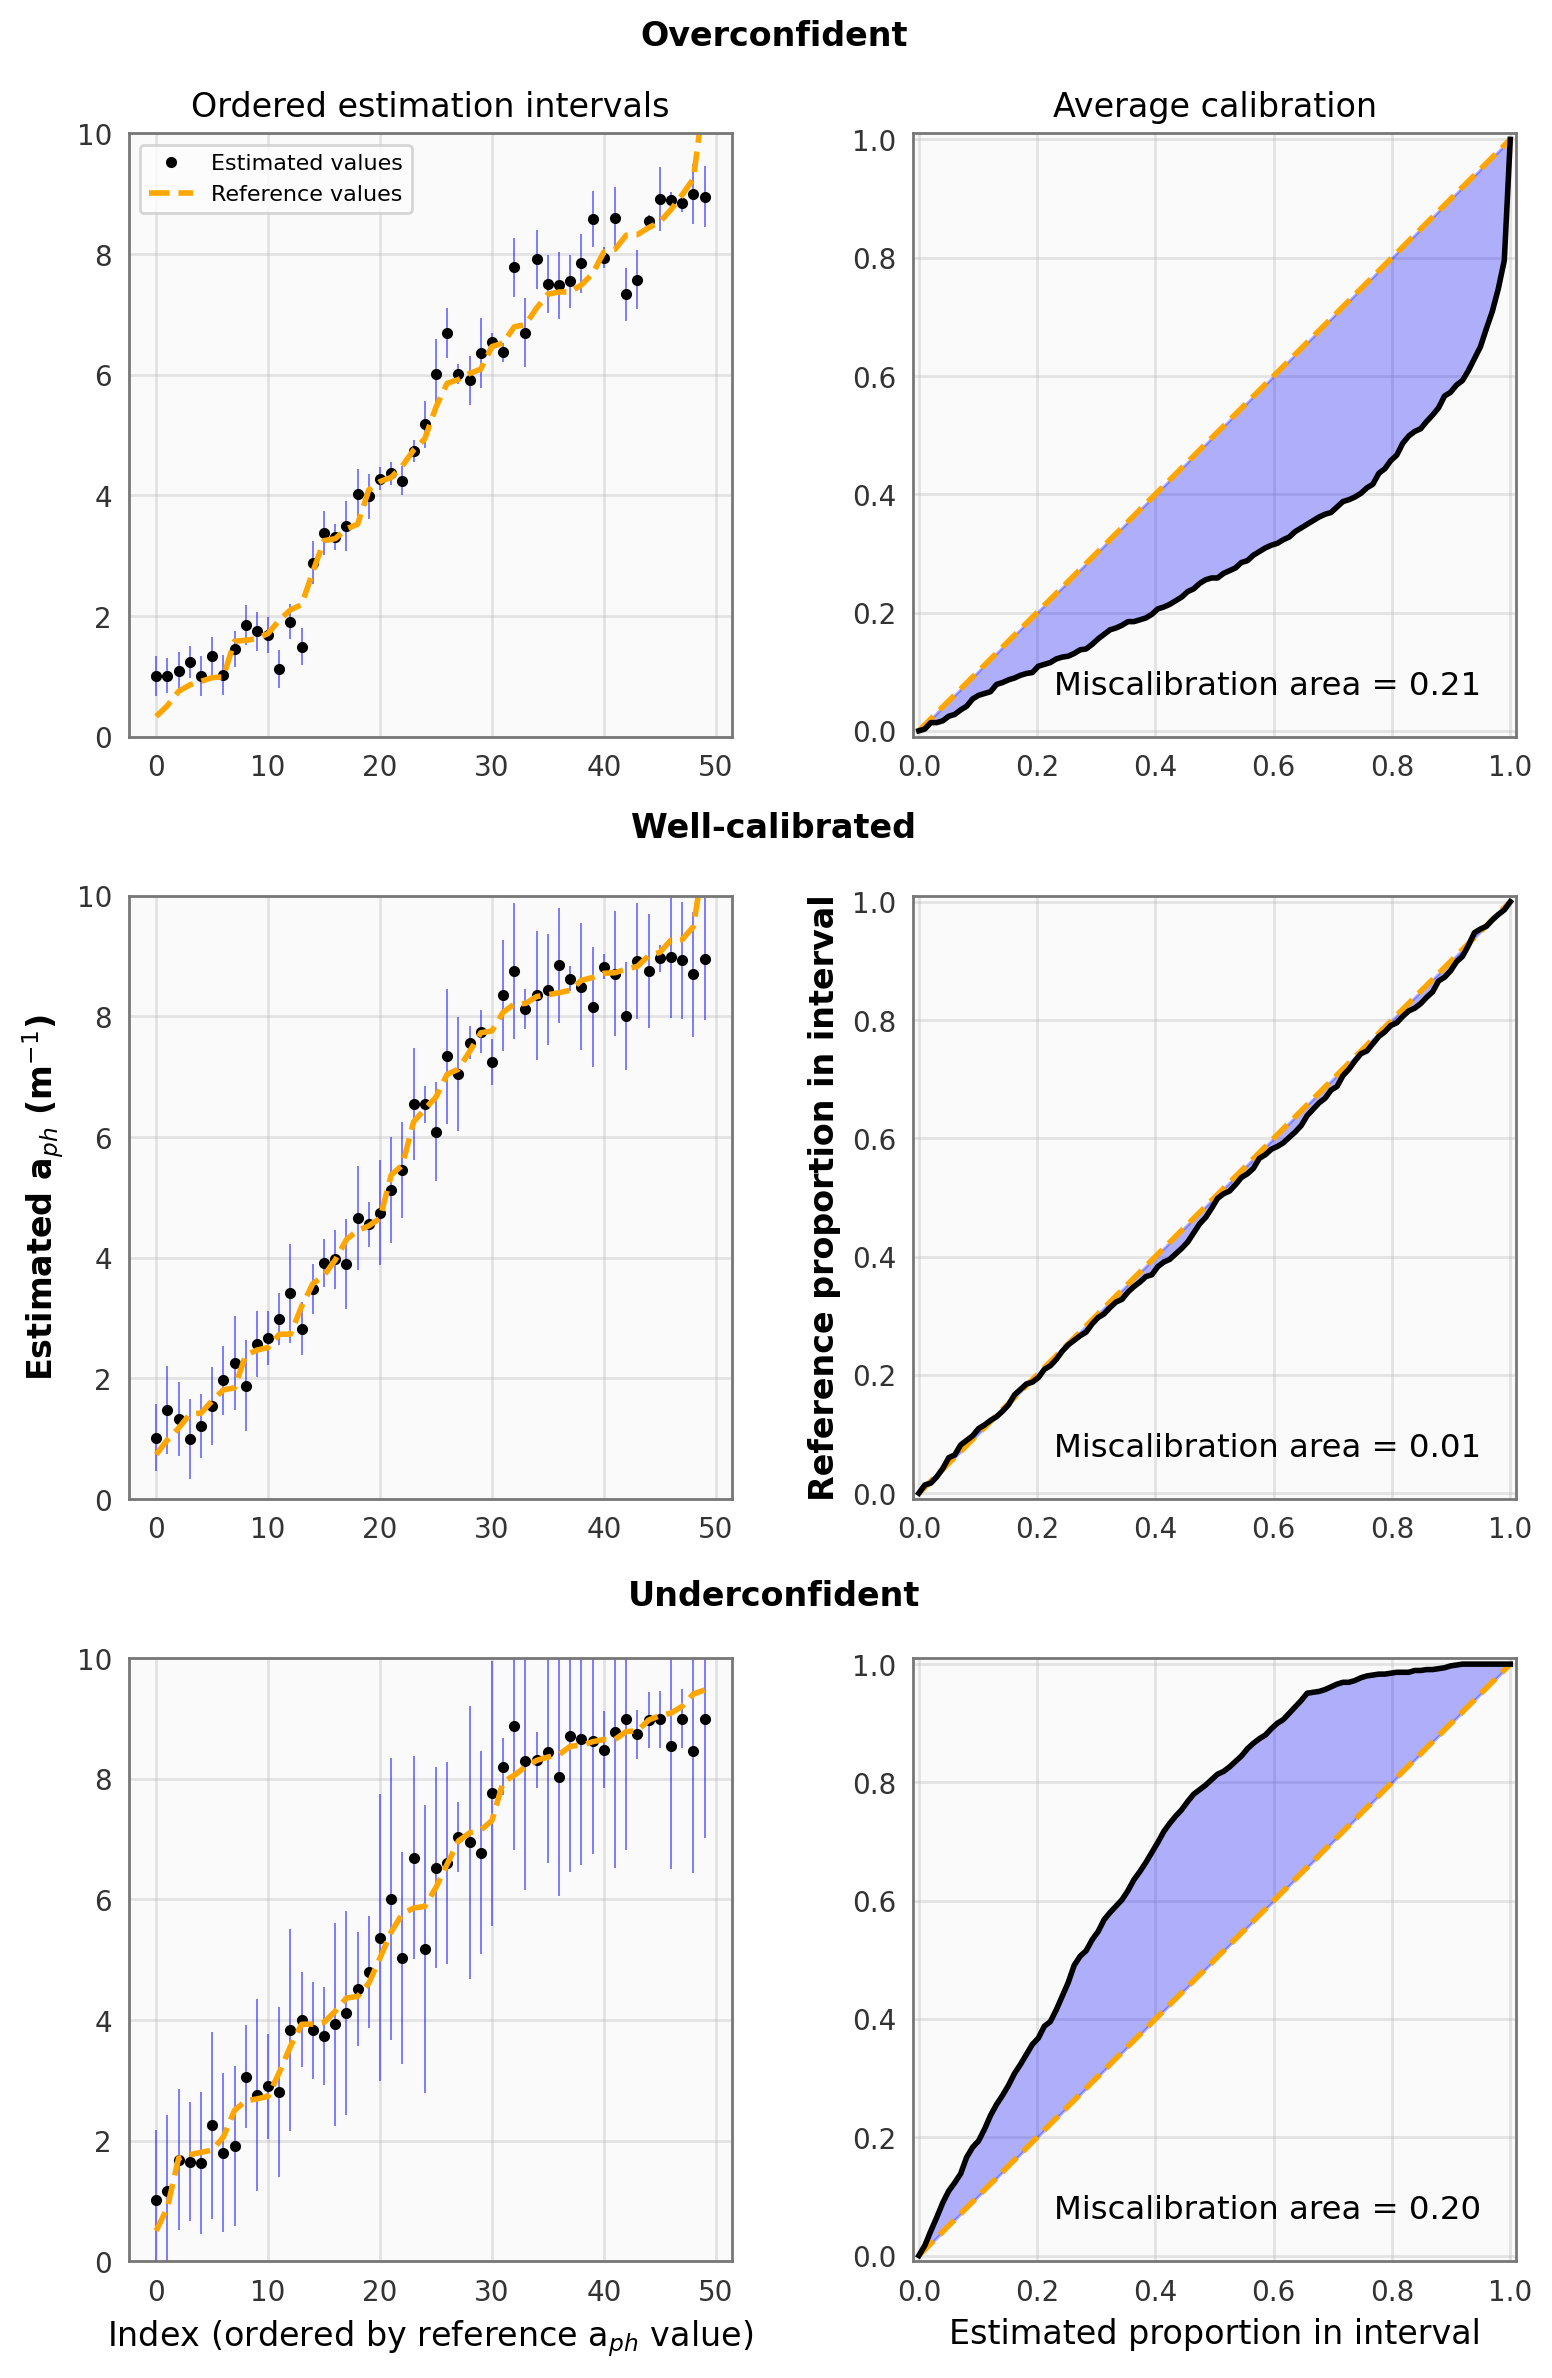

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct
from scipy.stats import norm  # Add this import
from typing import Union
from typing import Tuple
from typing import List
from typing import Any
Numeric = Union[int, float, np.ndarray]

# uct.viz.set_style()
# uct.viz.update_rc("text.usetex", False)  # Set to True for system latex
# uct.viz.update_rc("font.size", 14)  # Set font size
# uct.viz.update_rc("xtick.labelsize", 14)  # Set font size for xaxis tick labels
# uct.viz.update_rc("ytick.labelsize", 14)  # Set font size for yaxis tick labels

# Set font to a widely available sans-serif font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica', 'Verdana']

# Suppress font-related warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def modified_synthetic_sine_heteroscedastic(
    n_points: int = 650,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Return samples from modified "synthetic sine" heteroscedastic noisy function."""
    bounds = [0, 15]
    x = np.linspace(bounds[0], bounds[1], n_points)
    f = 5 + 4 * np.sin(x)  
    std = 0.1 + np.abs(x - 7.5) / 15.0  
    noise = np.random.normal(scale=std)
    y = f + noise
    return f, std, y, x

np.random.seed(666)

n_obs = 650
f, std, y, x = modified_synthetic_sine_heteroscedastic(n_obs)

def custom_filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list

def intersection(
    p1: Tuple[Numeric, Numeric],
    p2: Tuple[Numeric, Numeric],
    p3: Tuple[Numeric, Numeric],
    p4: Tuple[Numeric, Numeric],
) -> Tuple[Numeric, Numeric]:
    """
    Calculate the intersection of two lines between four points, as defined in
    https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection.

    This is an array option and works can be used to calculate the intersections of
    entire arrays of points at the same time.

    Args:
        p1: The point (x1, y1), first point of Line 1
        p2: The point (x2, y2), second point of Line 1
        p3: The point (x3, y3), first point of Line 2
        p4: The point (x4, y4), second point of Line 2

    Returns: The point of intersection of the two lines, or (np.nan, np.nan) if the lines are parallel

    """

    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    D = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / D
    y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / D

    return x, y

def trapezoid_area(
    xl: np.ndarray,
    al: np.ndarray,
    bl: np.ndarray,
    xr: np.ndarray,
    ar: np.ndarray,
    br: np.ndarray,
    absolute: bool = True,
) -> Numeric:
    """
    Calculate the area of a vertical-sided trapezoid, formed connecting the following points:
        (xl, al) - (xl, bl) - (xr, br) - (xr, ar) - (xl, al)

    This function considers the case that the edges of the trapezoid might cross,
    and explicitly accounts for this.

    Args:
        xl: The x coordinate of the left-hand points of the trapezoid
        al: The y coordinate of the first left-hand point of the trapezoid
        bl: The y coordinate of the second left-hand point of the trapezoid
        xr: The x coordinate of the right-hand points of the trapezoid
        ar: The y coordinate of the first right-hand point of the trapezoid
        br: The y coordinate of the second right-hand point of the trapezoid
        absolute: Whether to calculate the absolute area, or allow a negative area (e.g. if a and b are swapped)

    Returns: The area of the given trapezoid.

    """

    # Differences
    dl = bl - al
    dr = br - ar

    # The ordering is the same for both iff they do not cross.
    cross = dl * dr < 0

    # Treat the degenerate case as a trapezoid
    cross = cross * (1 - ((dl == 0) * (dr == 0)))

    # trapezoid for non-crossing lines
    area_trapezoid = (xr - xl) * 0.5 * ((bl - al) + (br - ar))
    if absolute:
        area_trapezoid = np.abs(area_trapezoid)

    # Hourglass for crossing lines.
    # NaNs should only appear in the degenerate and parallel cases.
    # Those NaNs won't get through the final multiplication so it's ok.
    with np.errstate(divide="ignore", invalid="ignore"):
        x_intersect = intersection((xl, bl), (xr, br), (xl, al), (xr, ar))[0]
    tl_area = 0.5 * (bl - al) * (x_intersect - xl)
    tr_area = 0.5 * (br - ar) * (xr - x_intersect)
    if absolute:
        area_hourglass = np.abs(tl_area) + np.abs(tr_area)
    else:
        area_hourglass = tl_area + tr_area

    # The nan_to_num function allows us to do 0 * nan = 0
    return (1 - cross) * area_trapezoid + cross * np.nan_to_num(area_hourglass)

def custom_miscalibration_area_from_proportions(
    exp_proportions: np.ndarray, obs_proportions: np.ndarray
) -> float:
    """Miscalibration area from expected and observed proportions lists.

    This function returns the same output as `miscalibration_area` directly from a list
    of expected proportions (the proportion of data that you expect to observe within
    prediction intervals) and a list of observed proportions (the proportion data that
    you observe within prediction intervals).

    Args:
        exp_proportions: expected proportion of data within prediction intervals.
        obs_proportions: observed proportion of data within prediction intervals.

    Returns:
        A single scalar that contains the miscalibration area.
    """
    areas = trapezoid_area(
        exp_proportions[:-1],
        exp_proportions[:-1],
        obs_proportions[:-1],
        exp_proportions[1:],
        exp_proportions[1:],
        obs_proportions[1:],
        absolute=True,
    )
    return areas.sum()

def custom_plot_intervals_ordered(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    n_subset: Union[int, None] = None,
    ylims: Union[Tuple[float, float], None] = None,
    num_stds_confidence_bound: int = 2,
    ax: Union[plt.Axes, None] = None,
    title: Union[str, None] = "Average calibration",
    xlabel: Union[str, None] = "Index (Ordered by Observed Value)",
    ylabel: Union[str, None] = "Phytoplankton absorption (m$^{-1}$)"
) -> plt.Axes:
    """Custom version of plot_intervals_ordered with modified colors and customizable labels."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    if n_subset is not None:
        [y_pred, y_std, y_true] = custom_filter_subset([y_pred, y_std, y_true], n_subset)
    order = np.argsort(y_true.flatten())
    y_pred, y_std, y_true = y_pred[order], y_std[order], y_true[order]
    xs = np.arange(len(order))
    intervals = num_stds_confidence_bound * y_std
   
    # Plot with updated colors
    ax.errorbar(xs, y_pred, intervals, fmt='none', ecolor='blue', alpha=0.5, lw=0.7)
    h1 = ax.plot(xs, y_pred, 'o', c='black', markersize=3, label="Estimated values")
    h2 = ax.plot(xs, y_true, '--', linewidth=2.0, c='orange', label="Reference values")
   
    #ax.legend(loc='lower right')
   
    ax.set_ylim([0, 10]) 
    
    if xlabel:
        ax.set_xlabel(xlabel,fontsize=12)
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=12,fontweight='bold')
    if title:
        ax.set_title(title,fontsize=12)
    
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")
    return ax

def custom_plot_calibration(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    n_subset: Union[int, None] = None,
    curve_label: Union[str, None] = None,
    vectorized: bool = True,
    exp_props: Union[np.ndarray, None] = None,
    obs_props: Union[np.ndarray, None] = None,
    ax: Union[plt.Axes, None] = None,
    prop_type: str = "interval",
    title: Union[str, None] = "Ordered prediction intervals",
    xlabel: Union[str, None] = "Predicted proportion in interval",
    ylabel: Union[str, None] = "Observed proportion in interval"
) -> plt.Axes:
    """Custom version of plot_calibration with modified colors and customizable labels."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    if n_subset is not None:
        [y_pred, y_std, y_true] = custom_filter_subset([y_pred, y_std, y_true], n_subset)
    if (exp_props is None) or (obs_props is None):
        if vectorized:
            exp_proportions, obs_proportions = uct.get_proportion_lists_vectorized(
                y_pred, y_std, y_true, prop_type=prop_type
            )
        else:
            exp_proportions, obs_proportions = uct.get_proportion_lists(
                y_pred, y_std, y_true, prop_type=prop_type
            )
    else:
        exp_proportions = np.array(exp_props).flatten()
        obs_proportions = np.array(obs_props).flatten()
        if exp_proportions.shape != obs_proportions.shape:
            raise RuntimeError("exp_props and obs_props shape mismatch")
    
    if curve_label is None:
        curve_label = "Predictor"
    
    ax.plot([0, 1], [0, 1], '--', label="Ideal", c='orange')
    ax.plot(exp_proportions, obs_proportions, label=curve_label, c='black')
    ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.3, color='blue')
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12,fontweight='bold')
    if title:
        ax.set_title(title, fontsize=12)
    
    ax.axis("square")
    buff = 0.01
    ax.set_xlim([0 - buff, 1 + buff])
    ax.set_ylim([0 - buff, 1 + buff])
    
    miscalibration_area = custom_miscalibration_area_from_proportions(
        exp_proportions=exp_proportions, obs_proportions=obs_proportions
    )
    ax.text(
        x=0.95,
        y=0.05,
        s=f"Miscalibration area = {miscalibration_area:.2f}",
        verticalalignment="bottom",
        horizontalalignment="right",
        fontsize="small",
    )
    return ax

def make_plots(pred_mean_list, pred_std_list, plot_save_str="scenarios"):
    """Make set of plots for each scenario with improved layout and manual scenario title placement."""
    ylims = [0, 10] 
    n_subset = 50
    fig, axs = plt.subplots(3, 2, figsize=(8, 12))
    fig.patch.set_facecolor('white')
    
    scenarios = ["Overconfident", "Well-calibrated", "Underconfident"]
   
    scenario_positions = [0.98, 0.65, 0.33]
   
    for i, (pred_mean, pred_std) in enumerate(zip(pred_mean_list, pred_std_list)):
        # Ordered intervals plot
        axs[i, 0] = custom_plot_intervals_ordered(
            pred_mean, pred_std, y, n_subset=n_subset, ylims=ylims, ax=axs[i, 0],
            title="Ordered estimation intervals" if i == 0 else None,
            xlabel="Index (ordered by reference a$_{ph}$ value)" if i == 2 else None,
            ylabel="Estimated a$_{ph}$ (m$^{-1}$)" if i == 1 else None
        )
       
        # Calibration plot
        axs[i, 1] = custom_plot_calibration(
            pred_mean, pred_std, y, ax=axs[i, 1],
            title="Average calibration" if i == 0 else None,
            xlabel="Estimated proportion in interval" if i == 2 else None,
            ylabel="Reference proportion in interval" if i == 1 else None
        )
        fig.text(0.5, scenario_positions[i], scenarios[i], fontsize=12, fontweight='bold', ha='center')
   
        # Add legend only to the top-left plot and remove from others if they exist
        if i == 0:
            axs[i, 0].legend(loc='upper left', fontsize=8)
        else:
            legend = axs[i, 0].get_legend()
            if legend:
                legend.remove()
        
        legend = axs[i, 1].get_legend()
        if legend:
            legend.remove()
   
    # Adjust subplots spacing
    fig.tight_layout()
    fig.subplots_adjust(top=0.95, bottom=0.05, hspace=0.2, wspace=0.3)

    # Set font size for x and y axis ticks
    for ax in axs.flatten():
        ax.tick_params(axis='both', which='major', labelsize=10)

    plt.savefig('fig_4.png', dpi=200, bbox_inches='tight')

# Usage
pred_mean_list = [f] * 3  # Same mean for all scenarios
pred_std_list = [
    std * 0.5,  # overconfident
    std,        # well-calibrated
    std * 2.0,  # underconfident
]

make_plots(pred_mean_list, pred_std_list)

 
scenarios = ["Overconfident", "Well-calibrated", "Underconfident"]
# Metrics for each scenario
for i, (pred_mean, pred_std) in enumerate(zip(pred_mean_list, pred_std_list)):
    mace = uct.mean_absolute_calibration_error(pred_mean, pred_std, y)
    rmsce = uct.root_mean_squared_calibration_error(pred_mean, pred_std, y)
    ma = uct.miscalibration_area(pred_mean, pred_std, y)
    print(f"{scenarios[i]}: MACE: {mace:.4f}, RMSCE: {rmsce:.4f}, MA: {ma:.4f}")